# Install Package

In [1]:
# !pip install swtloc

# Imports

In [2]:
from swtloc import SWTLocalizer
from swtloc.utils import auto_canny, imgshowN, imgshow
import numpy as np

from cv2 import cv2

# Path Declarations & Handle Initialisations

In [3]:
imgrootpath = '../images/'

swtl = SWTLocalizer()

# Stroke Width Transform of Image

- Generating SWT of image
- Understanding parameters of the swttransform() function

* CC : Connected Component

In [4]:
imgpath = imgrootpath+'test_img2.jpg'

In [5]:
swtl.swttransform(imgpaths=imgpath)

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



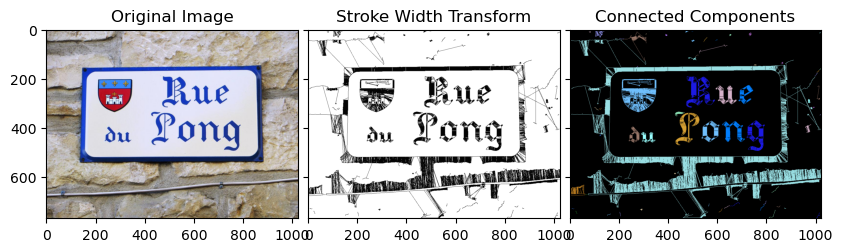

In [6]:
# Plotting three variants of the images during the process of the
# transformation -> Original > Stroke Width Transform > Connected Components
imgshowN([swtl.orig_img, swtl.swt_mat, swtl.swt_labelled3C],
         ['Original Image', 'Stroke Width Transform', 'Connected Components'])

**Time Taken while SWT transformation**

In [7]:
print('Time Taken : ', swtl.transform_time)

Time Taken :  15.301 sec


**Visualising The intermediary steps**

During the process of the Stroke Width transform, there are multiple steps that go in while generating the end result. Below mentioned are the two steps that go in before the end result is reached. 
    - Edge Image (Tricky One).
    - Image Gradient.
    
**swtloc** gives an option of visualing these stages, and can be accessed as stated in the next code cell

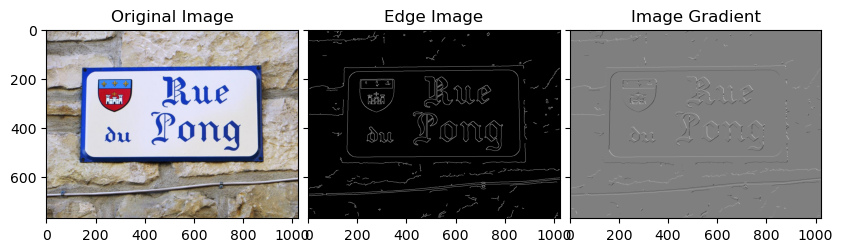

In [8]:
imgshowN([swtl.orig_img, swtl.grayedge_img, swtl.img_gradient],
         ['Original Image', 'Edge Image', 'Image Gradient'])

**Text Mode parameter**

This is image specific, but an extremely important parameter that takes one of the two value :-
- db_lf :> **D**ark **B**ackground **L**ight **F**oreground i.e Light color text on Dark color background
- lb_df :> **L**ight **B**ackground **D**ark **F**oreground i.e Dark color text on Light color background

This parameters affect how the gradient vectors (the direction) are calulated, since gradient vectors of **db_lf** are in $-ve$ direction to that of **lb_df** gradient vectors

In [9]:
swtl.swttransform(imgpaths=imgpath, text_mode = 'db_lf')
db_lf_swt = swtl.swt_mat.copy()

swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df')
lb_df_swt = swtl.swt_mat.copy()

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



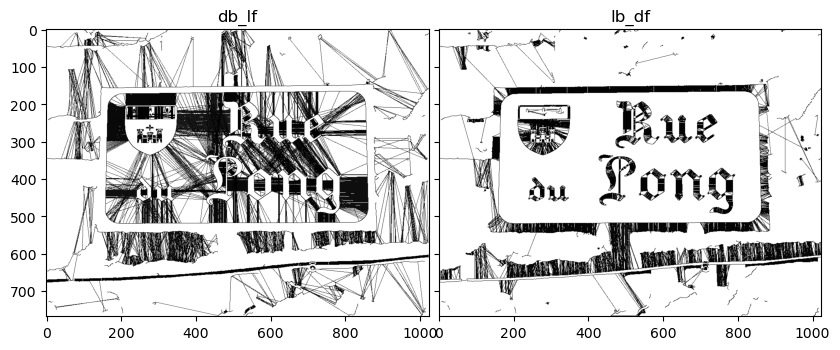

In [10]:
imgshowN([db_lf_swt, lb_df_swt],
         ['db_lf', 'lb_df'])

**Gaussian Blurr**

Right after an image is read from the path provided, the image will be converted into grayscale (default). To contol this operation following parameter can be used :-

- gs_blurr = True :> Wether to blurr an image or not.
    - blurr_kernel = (5,5) [If gs_blurr = True] :> The kernel size for the operation


In [11]:
swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', blurr_kernel = (11,11))
blurr_swt = swtl.swt_mat.copy()
blurr_tt = swtl.transform_time

swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', gs_blurr = False)
nonblurr_swt = swtl.swt_mat.copy()
noblurr_tt = swtl.transform_time


MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



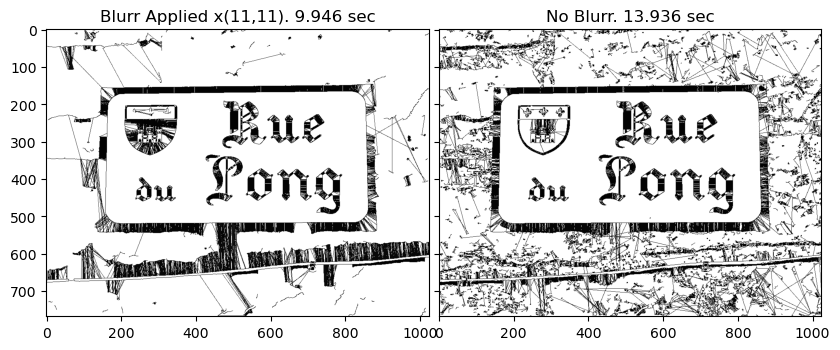

In [12]:
imgshowN([blurr_swt, nonblurr_swt],
         ['Blurr Applied x(11,11). '+blurr_tt, 'No Blurr. '+noblurr_tt])

**Image Edging**

Finding the Edge of the image is a tricky part, this is pertaining to the fact that in most of the cases the images we deal with are of not that standard that applying just a opencv Canny operator would result in the desired Edge Image.

Sometimes (In most cases) there is some custom processing required before edging, for that reason alone this function accepts one of the following two arguments :- 

- 'ac' :> Auto-Canny function, an in-built function which will generate the Canny Image from the original image, internally calculating the threshold parameters, although, to tune it even further 'ac_sigma' parameter is provided which can take any value between 0.0 <--> 1.0 .
- *A custom function* : This function should have its signature as mentioned below :

    def custom_edge_func(gray_image):

        Your Function Logic...

        edge_image = ...
        
        return edge_image
    

In [13]:
# Default value of ac_sigma is 0.33
swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', edge_func = 'ac')
default_edge = swtl.swt_mat.copy()

swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', edge_func = 'ac', ac_sigma = 1.0)
sigma1_edge = swtl.swt_mat.copy()


MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



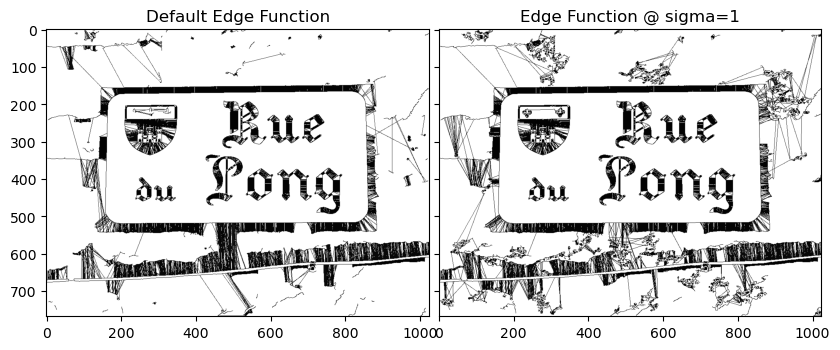

In [14]:
imgshowN([default_edge, sigma1_edge],
         ['Default Edge Function', 'Edge Function @ sigma=1'])

In [15]:
def custom_edge_func(gray_image):
    
    gauss_image = cv2.GaussianBlur(gray_image, (5,5), 1)
    laplacian_conv = cv2.Laplacian(gauss_image, -1, (5,5))
    canny_edge = cv2.Canny(laplacian_conv, 20, 140)
    
    return canny_edge

In [16]:
swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', edge_func = 'ac')
default_edge = swtl.swt_mat.copy()

swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', edge_func = custom_edge_func)
custom_edge = swtl.swt_mat.copy()


MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



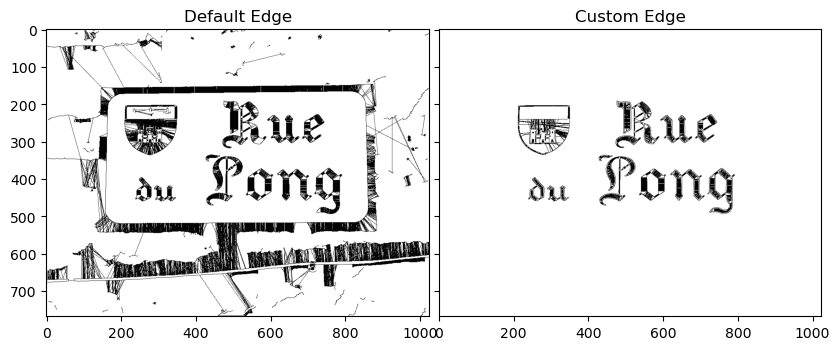

In [17]:
imgshowN([default_edge, custom_edge],
         ['Default Edge', 'Custom Edge'])

**Stroke Width Internal Parameters**

These parameters play role, while the finding strokes in the image from the Edge Image so generated in the prior stage.

- minrsw, (default=3) :> Minimum stroke width
- maxrsw, (default=200) :> Maximum stroke width


- check_anglediff, default(True) :> Wether to check the angle deviation of originating edge pixel to the final resting pixel
    - max_angledev, default(np.pi/6) :> Permissible value of the angle deviation


In [18]:
swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', edge_func = 'ac',
                  minrsw=3,maxrsw=10)
small_strokes = swtl.swt_mat.copy()

swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', edge_func = 'ac',
                  minrsw=3, maxrsw=500)
big_strokes = swtl.swt_mat.copy()

swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', edge_func = 'ac',
                 max_angledev=np.pi/2)
big_angledev = swtl.swt_mat.copy()


MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



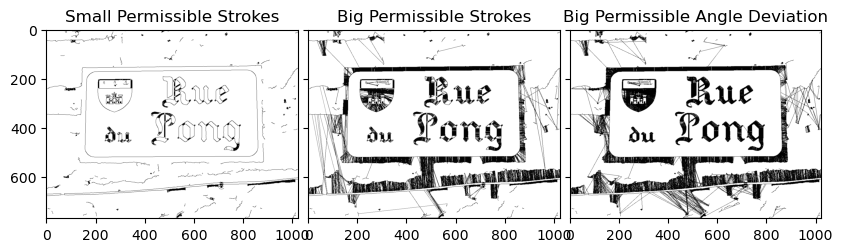

In [19]:
imgshowN([small_strokes, big_strokes, big_angledev],
         ['Small Permissible Strokes', 'Big Permissible Strokes', 'Big Permissible Angle Deviation'])

**Pruning Parameters**
Once the SWT transform on the image is complete, these parameters govern the pruning of the connected components in the resultant image :-

- minCC_comppx, (default = 50) :> Minimum number of Pixels to be in a connected component, smaller than this will be filtered out.

- maxCC_comppx, (default = 10000) :> Maximum number of Pixels to be in a connected component, larger than this will be filtered out.

- acceptCC_aspectratio, (default = 5) :> Aspect ratio(Width/Height) should be smaller than the inverse of this parameter.

In [20]:
swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', edge_func = 'ac',
                  minCC_comppx = 50, maxCC_comppx = 1000)
max1000_CC = swtl.swtlabelled_pruned13C.copy()

swtl.swttransform(imgpaths=imgpath, text_mode = 'lb_df', edge_func = 'ac',
                  minCC_comppx = 50, maxCC_comppx = 10000)
max10000_CC = swtl.swtlabelled_pruned13C.copy()

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



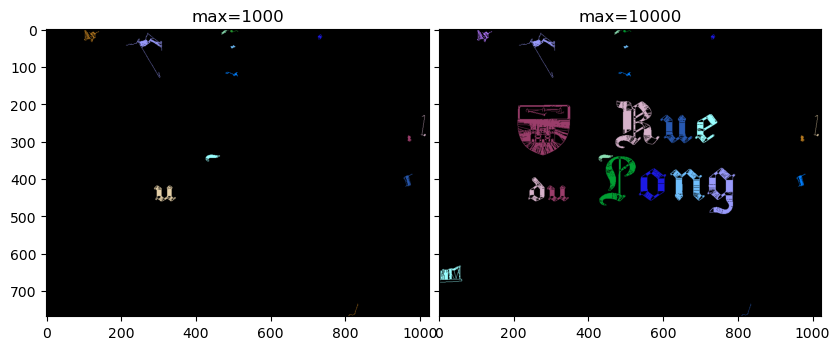

In [21]:
imgshowN([max1000_CC, max10000_CC],
         ['max=1000', 'max=10000'])

# Generating Minimum BBoxes

In [22]:
imgpath = imgrootpath+'test_img3.jpg'

In [23]:
swtl.swttransform(imgpaths=imgpath, text_mode='db_lf',
                  blurr_kernel = (11,11), max_angledev=np.pi/8, maxrsw=50)

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



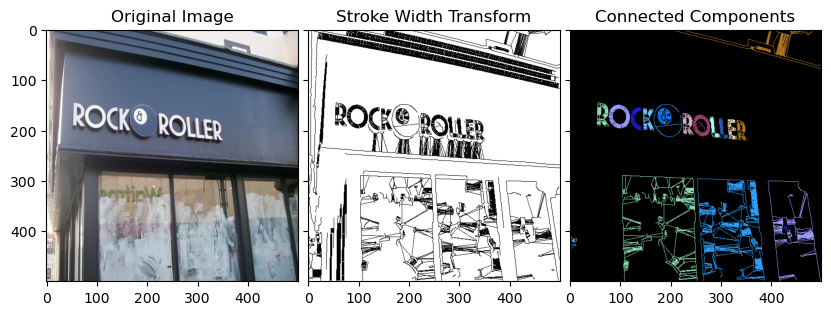

In [24]:
imgshowN([swtl.orig_img, swtl.swt_mat, swtl.swtlabelled_pruned13C],
         ['Original Image', 'Stroke Width Transform', 'Connected Components'])

**Generate Minimum Boundging Boxes**

Generates *Minimum Area Reactagle* around the recognised component.

Two parameters:-
- show :> Wether to show the plot or not
- padding :> Number of pixels to expand the given rectangle in their diagonal direction

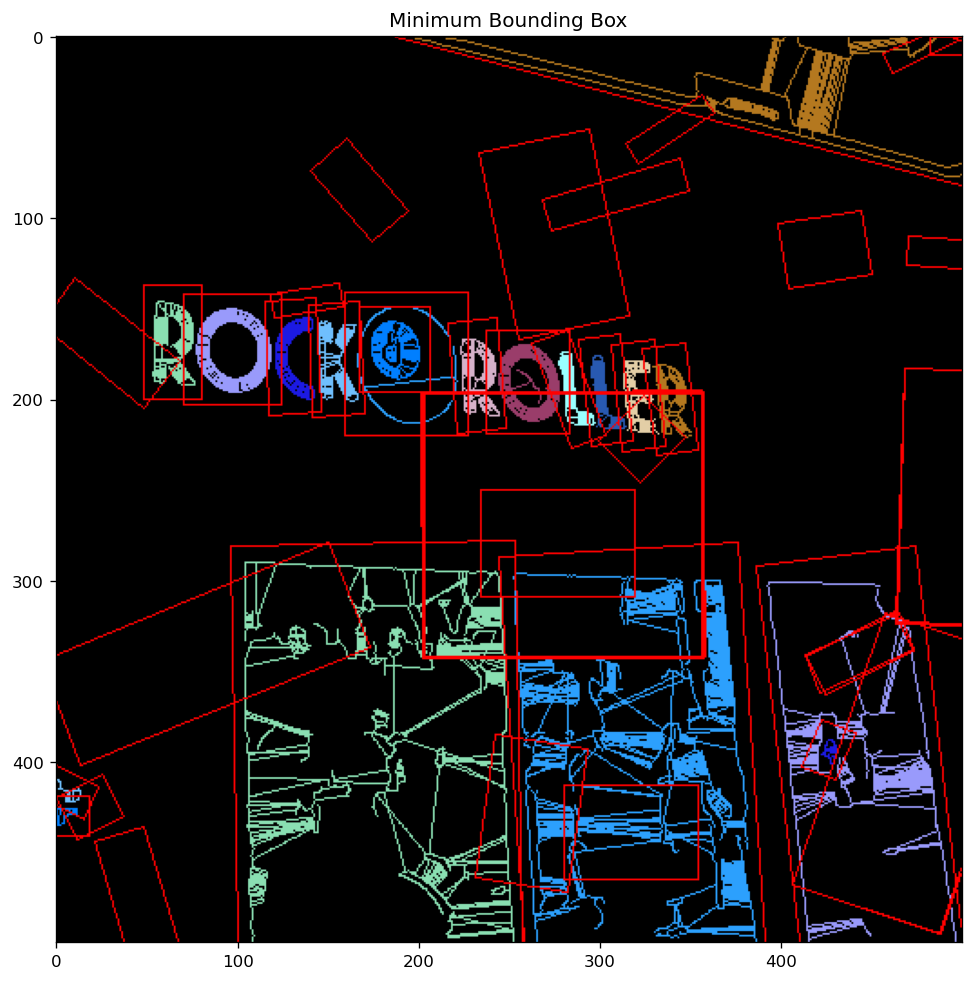

In [25]:
min_bboxes, min_bbox_annotated = swtl.get_min_bbox(show=True, padding=10)

# Generate External Bounding Boxes

In [26]:
imgpath = imgrootpath+'test_img6.jpeg'

In [27]:
swtl.swttransform(imgpaths=imgpath, text_mode='lb_df', ac_sigma=1.0,
                  max_angledev=np.pi/3, maxrsw=50)

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



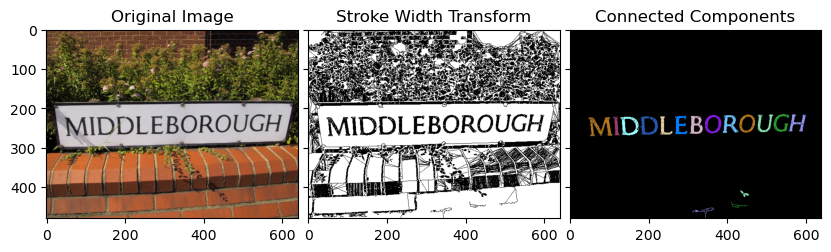

In [28]:
imgshowN([swtl.orig_img, swtl.swt_mat, swtl.swtlabelled_pruned13C],
         ['Original Image', 'Stroke Width Transform', 'Connected Components'])

**External Bounding Boxes**

Generates Bounding Box around the recognised component.

Two parameters:-
- show :> Wether to show the plot or not
- padding :> Number of pixels to expand the given rectangle

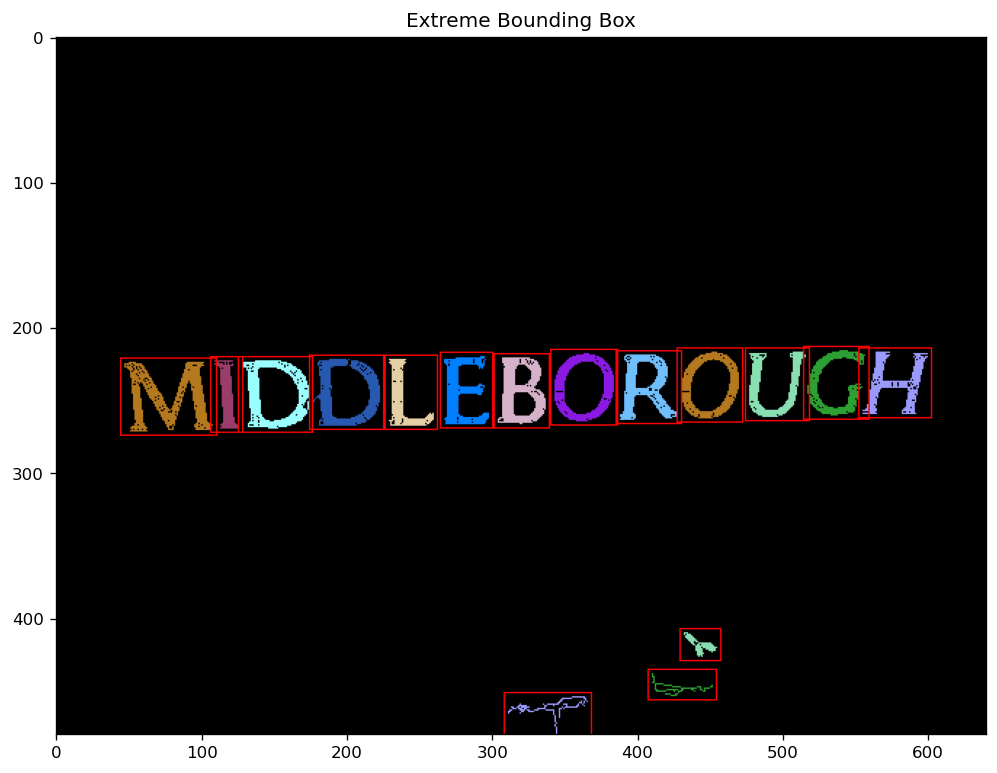

In [29]:
min_bboxes, min_bbox_annotated = swtl.get_extreme_bbox(show=True, padding=3)

# Generate Outline

In [30]:
imgpath = imgrootpath+'test_img9.jpg'

In [31]:
swtl = SWTLocalizer()
swtl.swttransform(imgpaths=imgpath, text_mode='db_lf', ac_sigma=1.0,
                  max_angledev=np.pi/3, maxrsw=50)

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



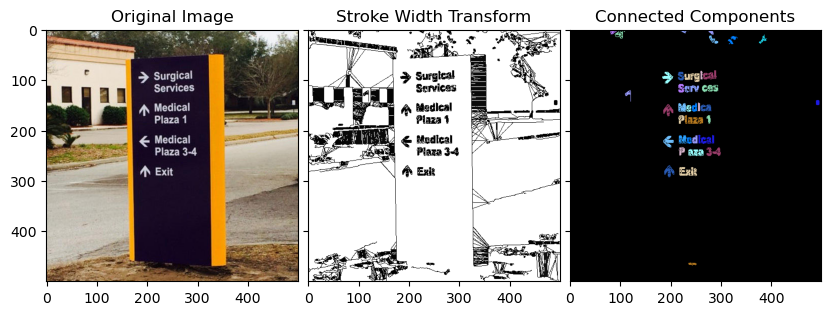

In [32]:
imgshowN([swtl.orig_img, swtl.swt_mat, swtl.swtlabelled_pruned13C],
         ['Original Image', 'Stroke Width Transform', 'Connected Components'])

**Outline**

Generates Outline (Contour) around the recognised component.

Two parameters:-
- show :> Wether to show the plot or not
- padding :> Number of pixels to expand the given rectangle

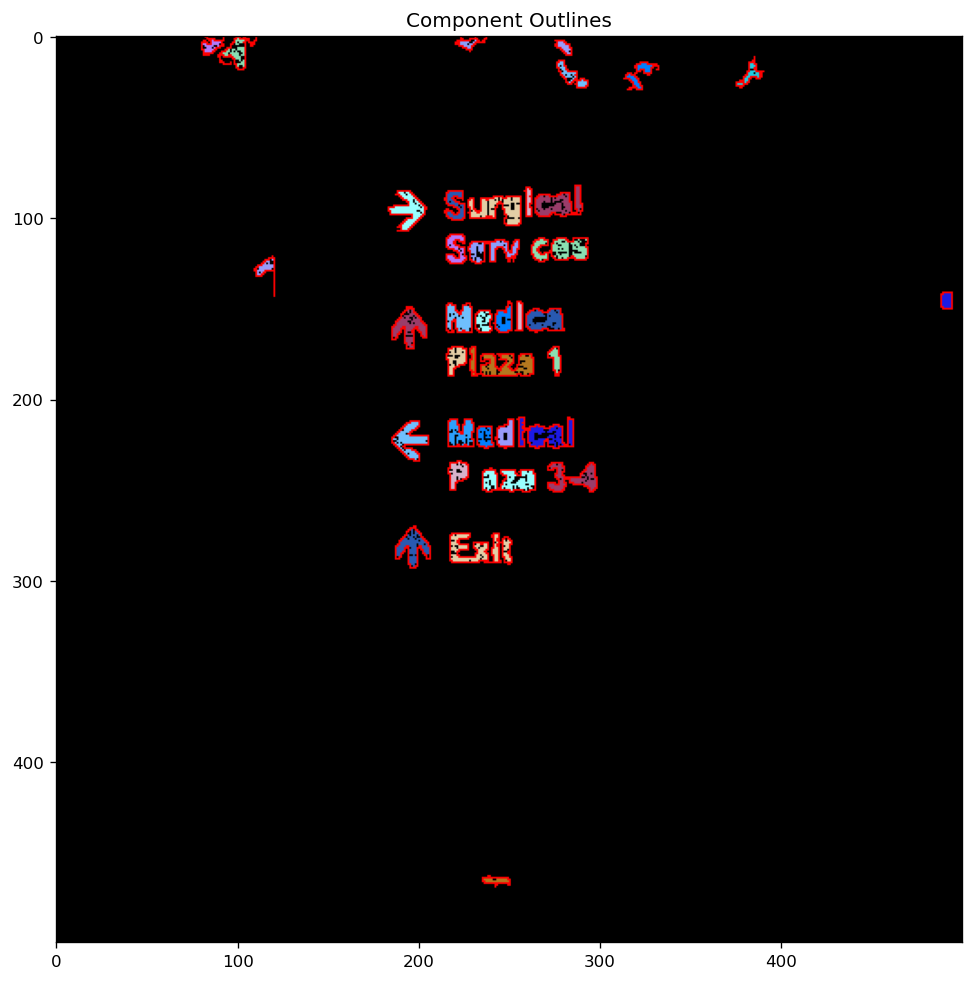

In [33]:
comp_outlines, comp_outline_annot = swtl.get_comp_outline(show=True)

# Generate Bubble Bounding Boxes

This function is responsible for grouping the letters together and generating a Bubble Bounding box around them, preserving the sense of orientation

In [34]:
imgpath = imgrootpath+'test_img7.jpg'

In [35]:
swtl = SWTLocalizer()
swtl.swttransform(imgpaths=imgpath, text_mode='db_lf',
                  max_angledev=np.pi/6, maxrsw=100, minrsw=10, acceptCC_aspectratio=3)

MainProcess @  |                COMPLETE                 | -> STATUS: 0.0% 1/1 Images Done. Transformations Complete



**Grouped Bubbled BBoxes**

This function groups the already available BBoxes into possible words, based on followinfg rules :-
- lookup_radii_multiplier : The radius in which each CC will look
- cl_deviat : The deviation in median color permissible $[\delta R,\delta G,\delta B]$ from the other component
- ht_ratio : The deviation in height permissible
- ar_ratio : The deviation in Aspect Ration permissible
- ang_deviat : The deviation allowed of minimum area rect from one CC to other

In [36]:
respacket = swtl.get_grouped(lookup_radii_multiplier=1, sw_ratio=2,
                     cl_deviat=[13,13,13], ht_ratio=2, 
                     ar_ratio=3, ang_deviat=30)

grouped_labels = respacket[0]
grouped_bubblebbox = respacket[1]
grouped_annot_bubble = respacket[2]
grouped_annot = respacket[3]
maskviz = respacket[4]
maskcomb  = respacket[5]

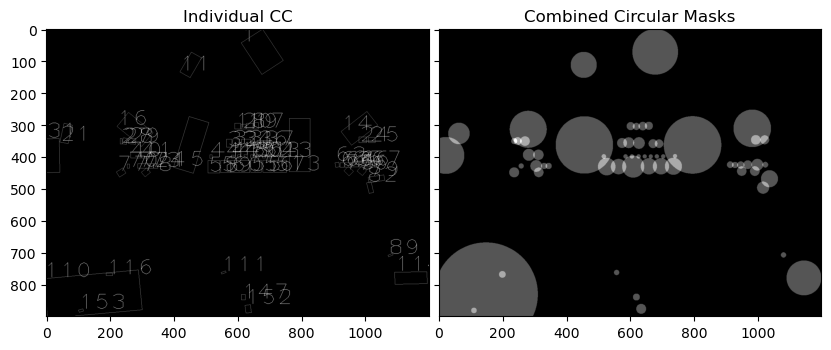

In [37]:
imgshowN([maskviz, maskcomb],
         ['Individual CC', 'Combined Circular Masks'])

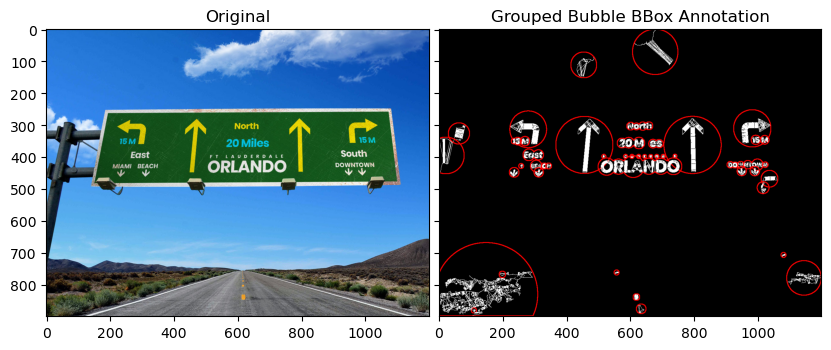

In [38]:
imgshowN([swtl.orig_img, grouped_annot_bubble],
         ['Original', 'Grouped Bubble BBox Annotation'])